In [6]:
!pip install tifffile

In [4]:
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import nrrd

In [5]:
# Define the folder containing the images
current_directory = os.getcwd()
print(os.getcwd())

C:\Users\prana\Desktop\CV_Project\Microscopy_Seg_CVProjectFall23


In [6]:
directory = current_directory + "\\tif\\"

Training Data:
Data shape: (165, 768, 1024)
Data type: uint8
Min and max values: 22, 244



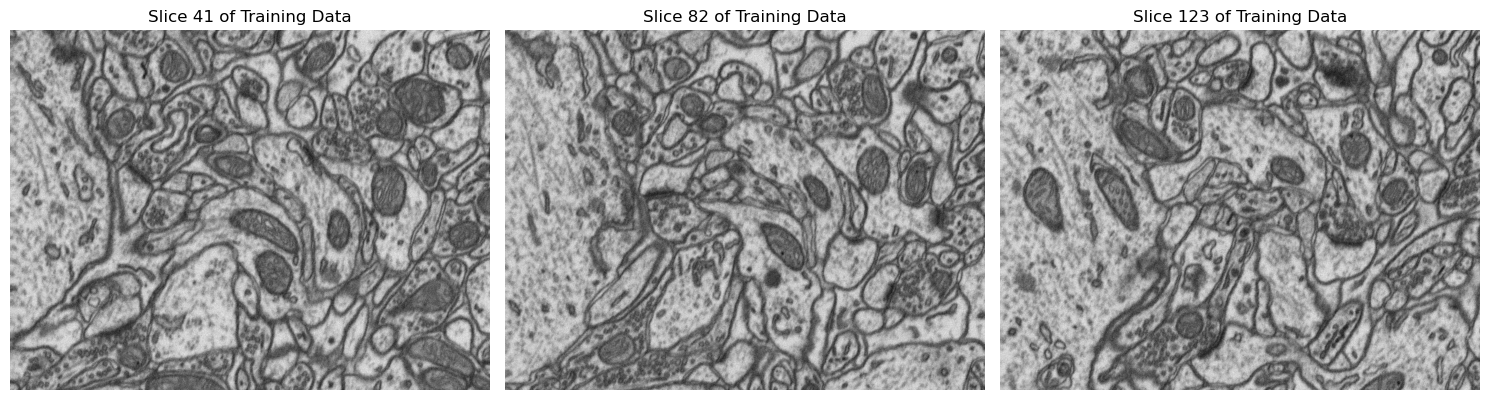

Training Groundtruth:
Data shape: (165, 768, 1024)
Data type: uint8
Min and max values: 0, 255



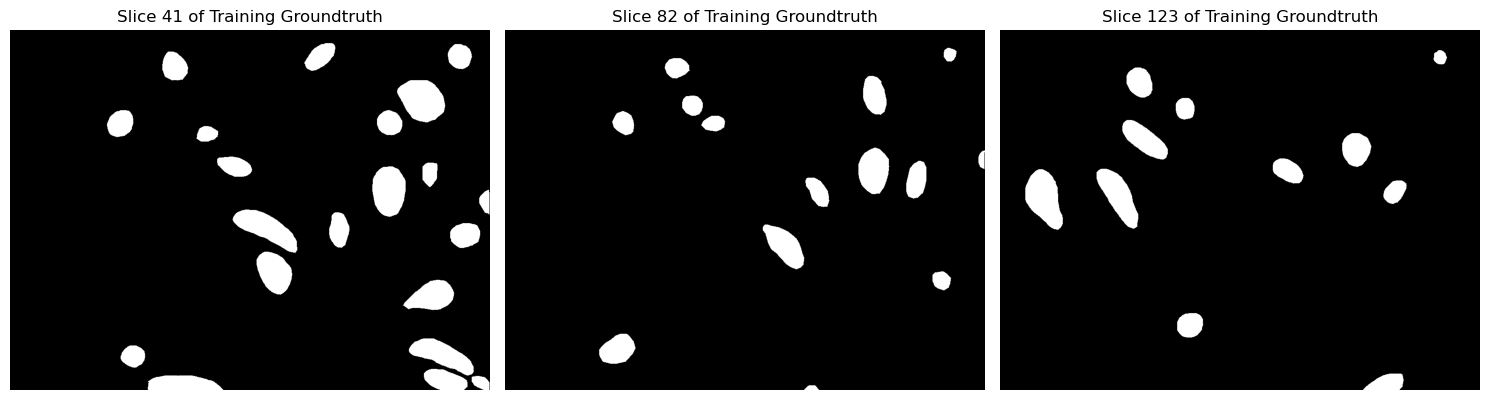

Testing Data:
Data shape: (165, 768, 1024)
Data type: uint8
Min and max values: 2, 255



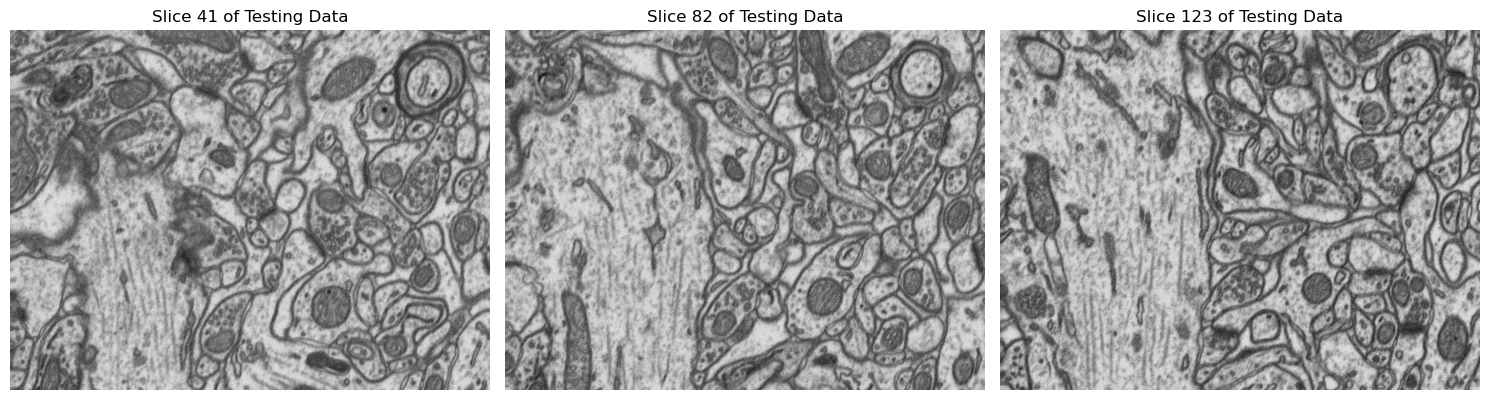

Testing Groundtruth:
Data shape: (165, 768, 1024)
Data type: uint8
Min and max values: 0, 255



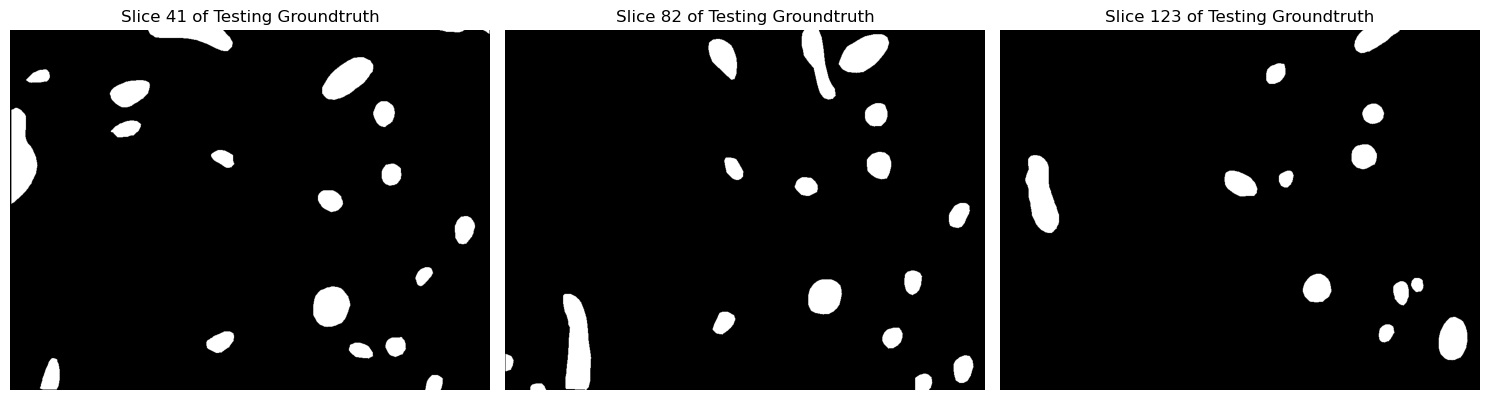

In [4]:
# Define the folder containing the images
current_directory = os.getcwd()
directory = current_directory + "\\tif\\" # replace with the path to your directory

# Load the files
train_data = tiff.imread(os.path.join(directory, 'training.tif'))
train_groundtruth = tiff.imread(os.path.join(directory, 'training_groundtruth.tif'))
test_data = tiff.imread(os.path.join(directory, 'testing.tif'))
test_groundtruth = tiff.imread(os.path.join(directory, 'testing_groundtruth.tif'))

datasets = {
    "Training Data": train_data,
    "Training Groundtruth": train_groundtruth,
    "Testing Data": test_data,
    "Testing Groundtruth": test_groundtruth
}

# Exploring and visualizing the datasets
for name, data in datasets.items():
    print(f"{name}:")
    print(f"Data shape: {data.shape}")
    print(f"Data type: {data.dtype}")
    print(f"Min and max values: {data.min()}, {data.max()}\n")

    # Visualize some slices
    num_slices = data.shape[0]
    sample_slices = [num_slices//4, num_slices//2, 3*num_slices//4]

    fig, axes = plt.subplots(1, len(sample_slices), figsize=(15, 5))
    for idx, slice_idx in enumerate(sample_slices):
        axes[idx].imshow(data[slice_idx, ...], cmap='gray')
        axes[idx].set_title(f'Slice {slice_idx} of {name}')
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

In [5]:


# Load the files
train_data = tiff.imread(os.path.join(directory, 'training.tif'))
train_groundtruth = tiff.imread(os.path.join(directory, 'training_groundtruth.tif'))
test_data = tiff.imread(os.path.join(directory, 'testing.tif'))
test_groundtruth = tiff.imread(os.path.join(directory, 'testing_groundtruth.tif'))

# Resize function
def resize_data(data):
    resized_data = np.zeros((165, 500, 500), dtype=np.uint8)
    for i in range(165):
        resized_data[i] = resize(data[i], (500, 500), preserve_range=True).astype(np.uint8)
    return resized_data

# Resize the data
train_data_resized = resize_data(train_data)
train_groundtruth_resized = resize_data(train_groundtruth)
test_data_resized = resize_data(test_data)
test_groundtruth_resized = resize_data(test_groundtruth)



NameError: name 'resize' is not defined

In [7]:
# Create directories to store resized images
resized_train_data_dir = os.path.join(directory, 'reTrain500')
resized_train_gt_dir = os.path.join(directory, 'reTrainGT500')
resized_test_data_dir = os.path.join(directory, 'reTest500')
resized_test_gt_dir = os.path.join(directory, 'reTestGT500')

os.makedirs(resized_train_data_dir, exist_ok=True)
os.makedirs(resized_train_gt_dir, exist_ok=True)
os.makedirs(resized_test_data_dir, exist_ok=True)
os.makedirs(resized_test_gt_dir, exist_ok=True)

# Save the resized data
for i in range(165):
    tiff.imsave(os.path.join(resized_train_data_dir, f'train_{i}.tif'), train_data_resized[i])
    tiff.imsave(os.path.join(resized_train_gt_dir, f'train_gt_{i}.tif'), train_groundtruth_resized[i])
    tiff.imsave(os.path.join(resized_test_data_dir, f'test_{i}.tif'), test_data_resized[i])
    tiff.imsave(os.path.join(resized_test_gt_dir, f'test_gt_{i}.tif'), test_groundtruth_resized[i])


**LOAD DATA HERE**

In [7]:
# Load resized images from folders
def load_resized_data(data_dir, filename):
    data = np.zeros((165, 500, 500), dtype=np.uint8)
    for i in range(165):
        data[i] = tiff.imread(os.path.join(data_dir, f'{os.path.basename(filename)}_{i}.tif'))
    return data

print(directory)

resized_train_data = load_resized_data(directory + "reTrain500", "train")
resized_train_groundtruth = load_resized_data(directory + "reTrainGT500", "train_gt" )
resized_test_data = load_resized_data(directory + "reTest500", "test")
resized_test_groundtruth = load_resized_data(directory + "reTestGT500", "test_gt")


C:\Users\prana\Desktop\CV_Project\Microscopy_Seg_CVProjectFall23\tif\


In [8]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2DTranspose,ZeroPadding2D,Conv2D,Add,Dropout,Input,UpSampling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import load_img,img_to_array,plot_model 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint,EarlyStopping,Callback

In [9]:
def decoder_block(input,skip_features, num_filters,conv_padding=False,zero_pad=False):

    x= Conv2DTranspose(num_filters, 2, activation = 'relu',strides=(2,2), kernel_initializer = 'he_normal')(input)

    if zero_pad == True:
      x=ZeroPadding2D((1,1))(x)
    
    if conv_padding ==True:
        x=Conv2D(num_filters, 3, activation = 'relu', padding='same', kernel_initializer = 'he_normal')(x)
    else:
        x=Conv2D(num_filters, 2, activation = 'relu', kernel_initializer = 'he_normal')(x)
    
    x = Add()([x, skip_features])
    return x

In [10]:
def Unet_VGG19(input_size,n_classes):
    """ Input """
    inp = Input(input_size)
    """ Pre-trained Model """
    vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=inp)
    """ Encoder """
    E0=vgg19.get_layer("block1_conv2").output
    E0=Conv2D(128, 3, activation = 'relu', padding='same')(E0)
    E0=Conv2D(64, 3, activation = 'relu', padding='same')(E0)
    
    
    
    
    E1=vgg19.get_layer("block1_pool").output
    E1=Conv2D(128, 3, activation = 'relu', padding='same')(E1)
    E1=Conv2D(64, 3, activation = 'relu', padding='same')(E1)
    
    
    E2=vgg19.get_layer("block2_pool").output
    E2=Conv2D(128, 3, activation = 'relu', padding='same')(E2)
    
    
    E3=vgg19.get_layer("block3_pool").output
    E3=Conv2D(512, 3, activation = 'relu', padding='same')(E3)
    E3=Conv2D(256, 3, activation = 'relu', padding='same')(E3)
    
    
    E4=vgg19.get_layer("block4_pool").output
    E4=Conv2D(1024, 3, activation = 'relu', padding='same')(E4)
    E4=Conv2D(512, 3, activation = 'relu', padding='same')(E4)
    
    
    """ Bridge """
    B1=vgg19.get_layer("block5_pool").output
    B1=Conv2D(1024, 3, activation = 'relu', padding='same')(B1)
    
    """ Decoder """
    D1=decoder_block(B1,E4,512,zero_pad=True)
    
    
    D2=decoder_block(D1,E3,256,conv_padding=True)

    D3=decoder_block(D2,E2,128,zero_pad=True)

    D4=decoder_block(D3,E1,64,conv_padding=True)
    
    D5=decoder_block(D4,E0,64,conv_padding=True)

    """ Output """
    outputs=Conv2D(n_classes, 1, activation = 'sigmoid', padding = 'same')(D5)
    model = Model(inp,outputs, name="VGG19_U-Net")
    model.compile(optimizer = Adam(learning_rate = 1e-4), loss ='binary_crossentropy', metrics = ['accuracy' , tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1],threshold=0.6,name="IOU")])
    model.summary()
    return model

In [11]:
model=Unet_VGG19(input_size=(500,500,3),n_classes=1)

Model: "VGG19_U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 500, 500, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 500, 500, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 500, 500, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 250, 250, 64)         0         ['block1_conv2[0][0]']        
                                                                                        

                                                                                                  
 conv2d_4 (Conv2D)           (None, 125, 125, 128)        147584    ['block2_pool[0][0]']         
                                                                                                  
 add_2 (Add)                 (None, 125, 125, 128)        0         ['conv2d_12[0][0]',           
                                                                     'conv2d_4[0][0]']            
                                                                                                  
 conv2d_transpose_3 (Conv2D  (None, 250, 250, 64)         32832     ['add_2[0][0]']               
 Transpose)                                                                                       
                                                                                                  
 conv2d_2 (Conv2D)           (None, 250, 250, 128)        73856     ['block1_pool[0][0]']         
          

In [11]:
!pip install pydot
!pip install graphviz


     ---------------------------------------- 0.0/47.0 kB ? eta -:--:--
     ---------------------------------------- 47.0/47.0 kB ? eta 0:00:00
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [12]:

plot_model(model,show_shapes=True,show_layer_names=True,expand_nested=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [12]:
#for training data:
train_path= directory + "/Train"
val_path= directory + "/Val"

image_datagen = ImageDataGenerator(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    rescale=1/255.)
mask_datagen = ImageDataGenerator(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    rescale=1/255.)


In [13]:
B_size=8
seed = 1
image_generator = image_datagen.flow_from_directory(
    train_path,
    class_mode=None,
    classes=['images'],
    color_mode='rgb',
    seed=seed,
    batch_size=B_size,
    target_size=(500,500))

mask_generator = mask_datagen.flow_from_directory(
    train_path,
    classes=['masks'],
    color_mode='grayscale',
    class_mode=None,
    seed=seed,
    batch_size=B_size,
    target_size=(500,500))
# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

def train_generator_fn():

    for (img,mask) in train_generator:
        yield (img,mask)

Found 165 images belonging to 1 classes.
Found 165 images belonging to 1 classes.


In [14]:
#for validation:

image_datagen = ImageDataGenerator(rescale=1/255.)
mask_datagen = ImageDataGenerator(rescale=1/255.)
B_size=8
seed = 1
image_generator = image_datagen.flow_from_directory(
    val_path,
    class_mode=None,
    classes=['images'],
    color_mode='rgb',
    seed=seed,
    batch_size=B_size,
    target_size=(500,500))

mask_generator = mask_datagen.flow_from_directory(
    val_path,
    classes=['masks'],
    color_mode='grayscale',
    class_mode=None,
    seed=seed,
    batch_size=B_size,
    target_size=(500,500))
# combine generators into one which yields image and masks
val_generator = zip(image_generator, mask_generator)

def val_generator_fn():

    for (img,mask) in val_generator:
        yield (img,mask)

Found 165 images belonging to 1 classes.
Found 165 images belonging to 1 classes.


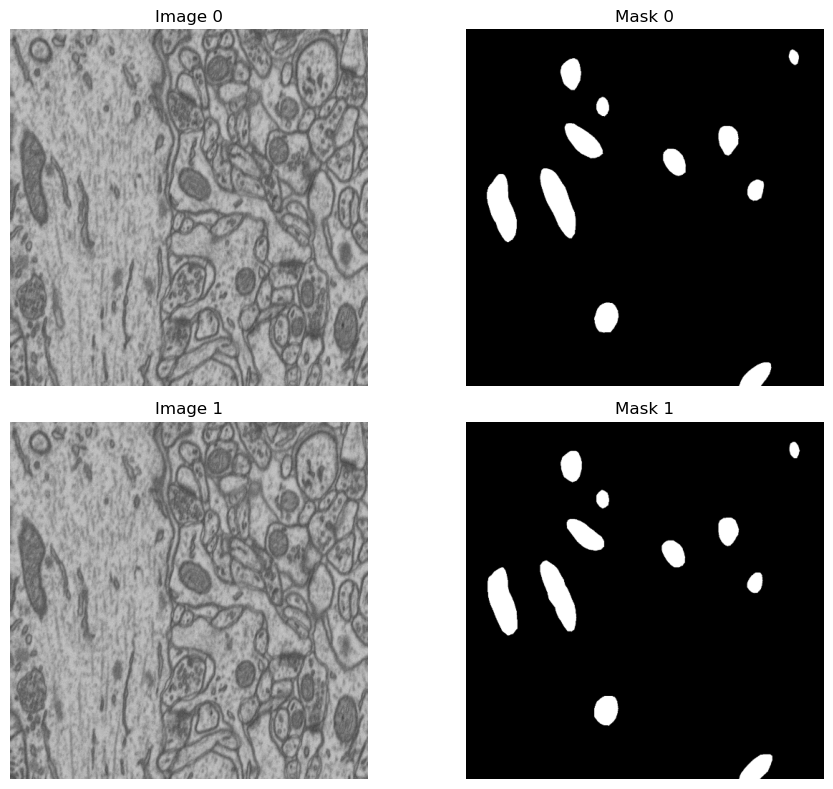

In [15]:
# Function to display images and masks
def display_images_masks(images, masks, num_samples=2):
    plt.figure(figsize=(10, num_samples * 4))
    
    for i in range(num_samples):
        # Display image
        plt.subplot(num_samples, 2, i * 2 + 1)
        plt.imshow(images[i])
        plt.title(f'Image {i}')
        plt.axis('off')

        # Display mask
        plt.subplot(num_samples, 2, i * 2 + 2)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title(f'Mask {i}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Load and display images and masks from the validation generator
val_images, val_masks = next(val_generator_fn())
display_images_masks(val_images, val_masks)


In [16]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Custom callback for tracking IoU and losses
class MetricsHistory(Callback):
    def __init__(self):
        self.iou_scores = []
        self.losses = []
        self.val_losses = []

    def on_epoch_end(self, epoch, logs=None):
        # Logs is a dictionary
        if logs is not None:
            self.iou_scores.append(logs.get('val_IOU'))  # Adjust this if your IoU metric name is different
            self.losses.append(logs.get('loss'))
            self.val_losses.append(logs.get('val_loss'))

# Initialize the custom callback
metrics_history = MetricsHistory()

# Other callbacks
model_checkpoint = ModelCheckpoint('CheckPoint.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, min_lr=1e-8)
early_stop = EarlyStopping(monitor="val_loss", patience=12, mode="auto", restore_best_weights=True)

# Model fitting
epochs = 25
validation_steps = 4
with tf.device('/gpu:0'):
    model.fit(train_generator_fn(),
              validation_data=val_generator_fn(),
              steps_per_epoch=21,
              validation_steps=validation_steps,
              epochs=epochs,
              callbacks=[model_checkpoint, reduce_lr, early_stop, metrics_history]
             )

# Access the recorded metrics
iou_scores = metrics_history.iou_scores
training_losses = metrics_history.losses
validation_losses = metrics_history.val_losses

# You can now use iou_scores, training_losses, and validation_losses as needed


Epoch 1/25
21/21 [==============================] - ETA: 0s - loss: 0.3473 - accuracy: 0.8887 - IOU: 0.4706 
Epoch 1: val_loss improved from inf to 0.23843, saving model to CheckPoint.hdf5


C:\Users\prana\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - 771s 36s/step - loss: 0.3473 - accuracy: 0.8887 - IOU: 0.4706 - val_loss: 0.2384 - val_accuracy: 0.9364 - val_IOU: 0.4761 - lr: 1.0000e-04
Epoch 2/25
21/21 [==============================] - ETA: 0s - loss: 0.1828 - accuracy: 0.9343 - IOU: 0.4806 
Epoch 2: val_loss did not improve from 0.23843
21/21 [==============================] - 727s 34s/step - loss: 0.1828 - accuracy: 0.9343 - IOU: 0.4806 - val_loss: 0.2510 - val_accuracy: 0.9354 - val_IOU: 0.4756 - lr: 1.0000e-04
Epoch 3/25
21/21 [==============================] - ETA: 0s - loss: 0.1376 - accuracy: 0.9369 - IOU: 0.4970 
Epoch 3: val_loss did not improve from 0.23843
21/21 [==============================] - 729s 35s/step - loss: 0.1376 - accuracy: 0.9369 - IOU: 0.4970 - val_loss: 0.3283 - val_accuracy: 0.9162 - val_IOU: 0.4763 - lr: 1.0000e-04
Epoch 4/25
21/21 [==============================] - ETA: 0s - loss: 0.0964 - accuracy: 0.9467 - IOU: 0.6450 
Epoch 4: val_loss did not improve from 

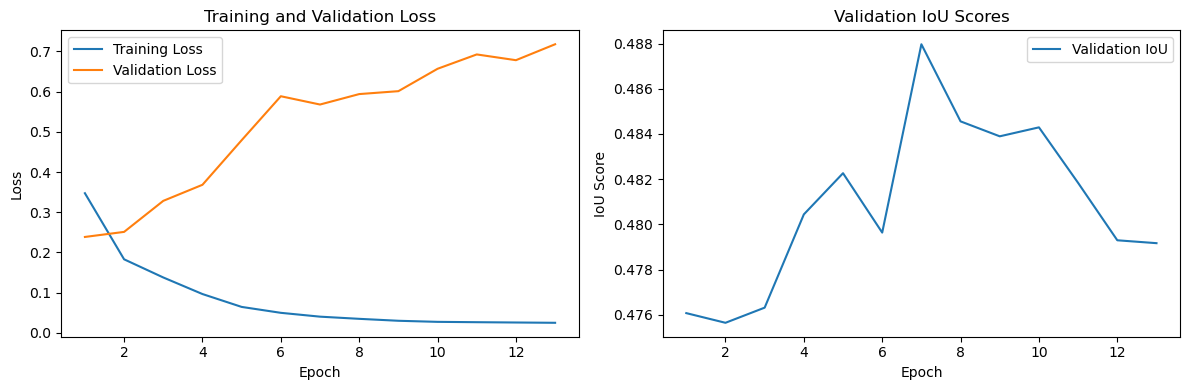

In [17]:
import matplotlib.pyplot as plt

# Assuming you have the following lists from the previous step:
iou_scores = metrics_history.iou_scores
training_losses = metrics_history.losses
validation_losses = metrics_history.val_losses

# Number of epochs - this should match the actual number of epochs run
epochs = range(1, len(training_losses) + 1)

# Plotting Training and Validation Loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, training_losses, label='Training Loss')
plt.plot(epochs, validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting IoU Scores
plt.subplot(1, 2, 2)
plt.plot(epochs, iou_scores, label='Validation IoU')
plt.title('Validation IoU Scores')
plt.xlabel('Epoch')
plt.ylabel('IoU Score')
plt.legend()

plt.tight_layout()
plt.show()


1/1 [==============================] - 1s 1s/step


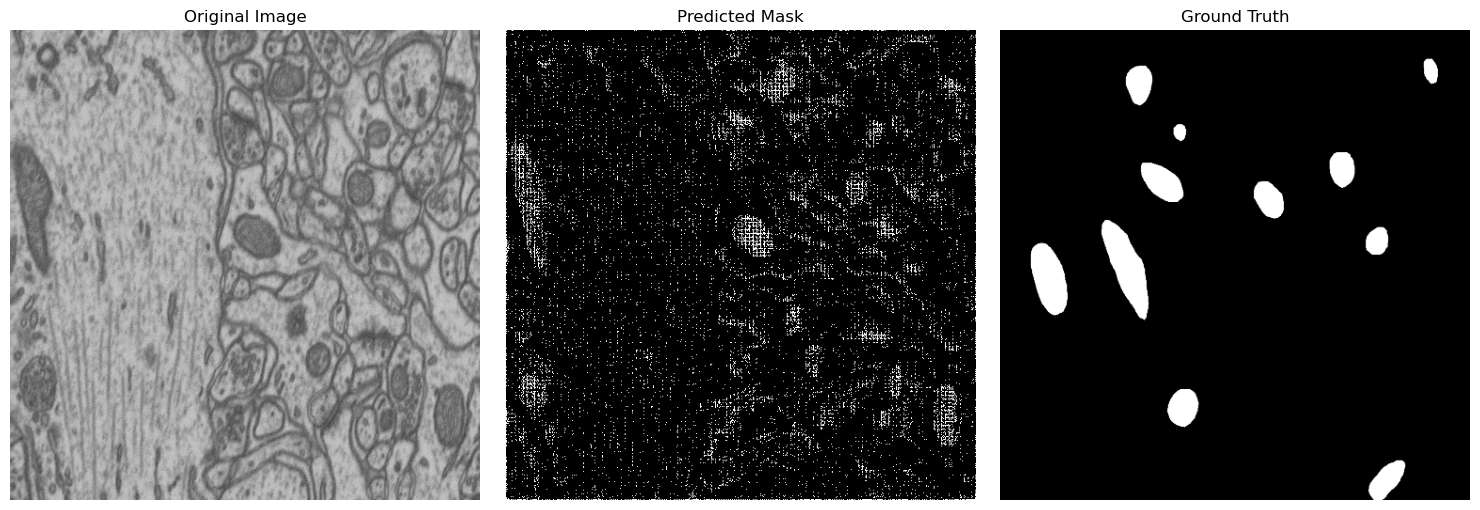

1/1 [==============================] - 1s 1s/step


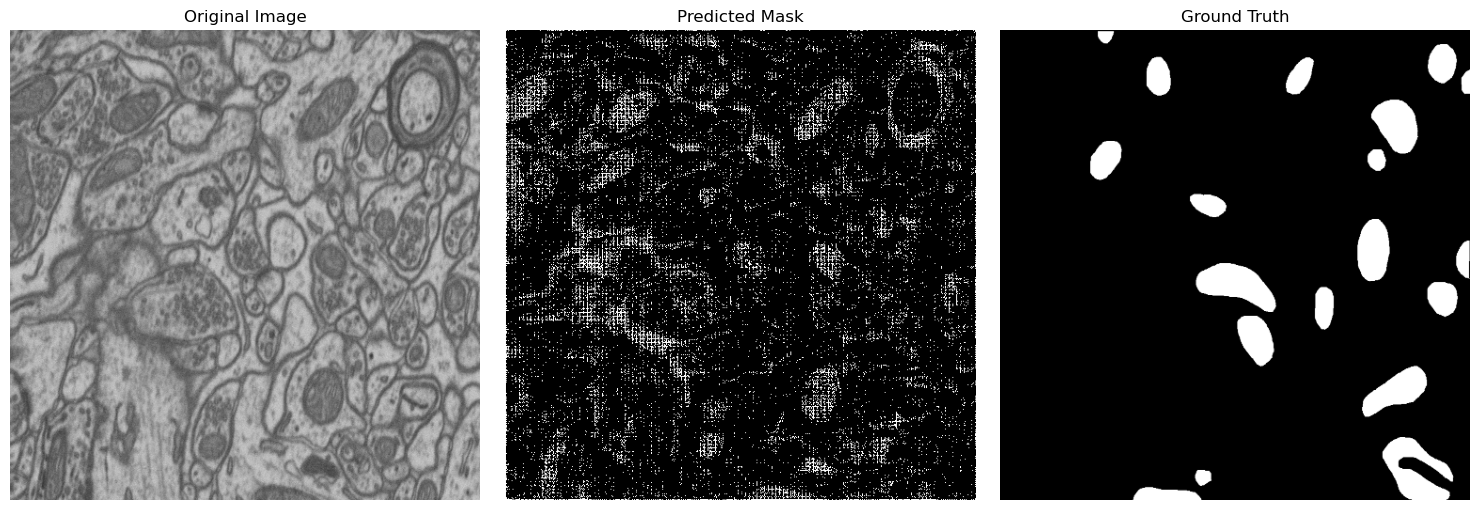

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Generate a batch of validation data
val_images, val_groundtruth = next(val_generator_fn())

# Randomly pick 2-3 indices from the batch of validation images
num_samples_to_show = random.choice([2, 3])
random_indices = random.sample(range(len(val_images)), num_samples_to_show)

for idx in random_indices:
    # Predicting on the sample image
    sample = np.expand_dims(val_images[idx], axis=0)  # Add batch dimension
    predicted_mask = model.predict(sample)
    predicted_mask = np.squeeze(predicted_mask, axis=(0, -1))  # Removing batch and channel dimensions

    # Threshold the prediction to get binary mask
    threshold = 0.08
    predicted_mask_binary = (predicted_mask > threshold).astype(np.uint8)

    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(val_images[idx], cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Predicted Mask
    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask_binary, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    # Ground Truth
    plt.subplot(1, 3, 3)
    plt.imshow(val_groundtruth[idx], cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [29]:
import matplotlib.pyplot as plt

# Function to display original images with post-processed predicted masks
def display_with_post_processed_masks(images, predicted_masks, post_processed_masks, num_samples):
    plt.figure(figsize=(15, num_samples * 5))

    for i in range(num_samples):
        # Original Image
        plt.subplot(num_samples, 3, 3*i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f'Original Image {i+1}')
        plt.axis('off')

        # Predicted Mask before Post-processing
        plt.subplot(num_samples, 3, 3*i + 2)
        plt.imshow(predicted_masks[i], cmap='gray')
        plt.title(f'Predicted Mask {i+1}')
        plt.axis('off')

        # Post-processed Predicted Mask
        plt.subplot(num_samples, 3, 3*i + 3)
        plt.imshow(post_processed_masks[i], cmap='gray')
        plt.title(f'Post-Processed Predicted Mask {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [25]:
# For validation (without augmentation)
val_image_datagen = ImageDataGenerator(rescale=1/255.)
val_mask_datagen = ImageDataGenerator(rescale=1/255.)

val_image_generator = val_image_datagen.flow_from_directory(
    val_path,
    classes=['images'],
    color_mode='rgb',
    class_mode=None,
    seed=seed,
    batch_size=B_size,
    target_size=(500, 500))

val_mask_generator = val_mask_datagen.flow_from_directory(
    val_path,
    classes=['masks'],
    color_mode='grayscale',
    class_mode=None,
    seed=seed,
    batch_size=B_size,
    target_size=(500, 500))

# Combine generators into one which yields image and masks
val_gen_no_aug = zip(val_image_generator, val_mask_generator)

def val_generator_no_aug_fn():
    for (img, mask) in val_gen_no_aug:
        yield (img, mask)


Found 165 images belonging to 1 classes.
Found 165 images belonging to 1 classes.


1/1 [==============================] - 9s 9s/step


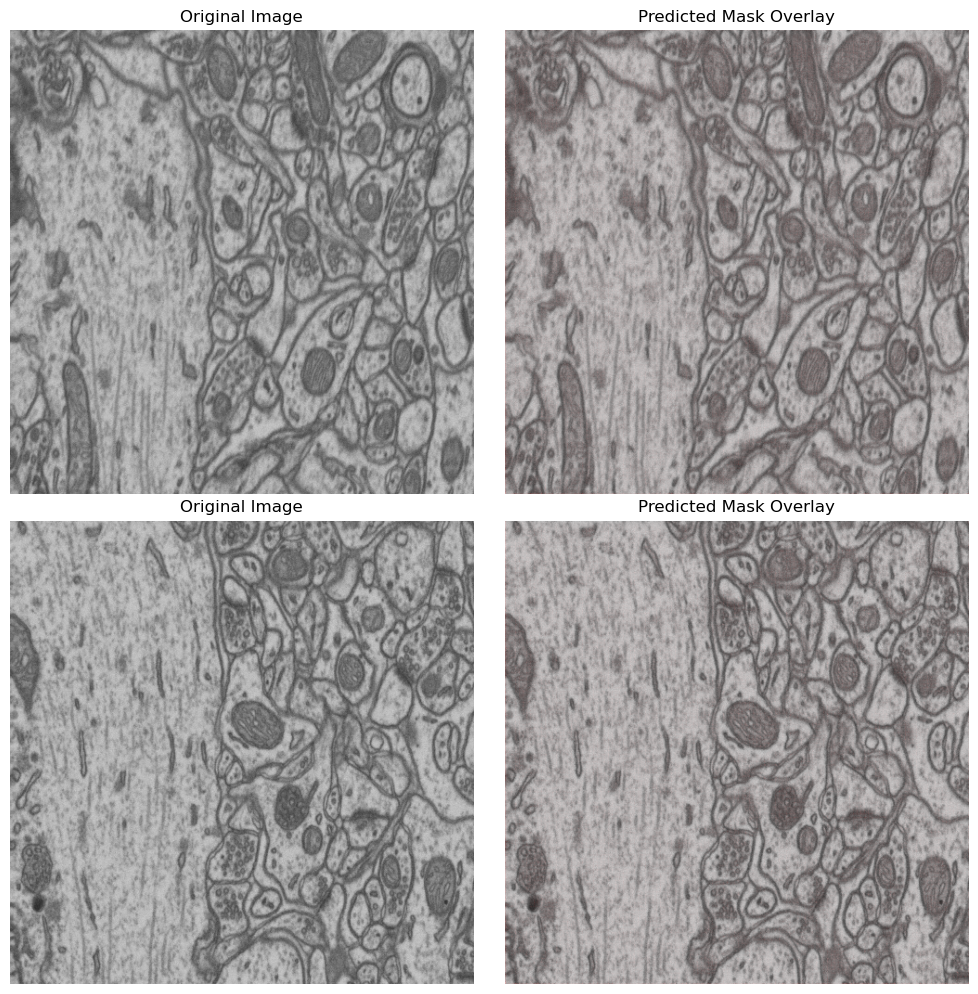

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Load a batch of images and masks from the validation generator
val_images, val_masks = next(val_generator_fn())

# Predict masks for a batch of validation images
predicted_masks = model.predict(val_images)

# Function to overlay masks on images
def overlay_mask(image, mask, color, alpha=0.5):
    """ Overlay `mask` onto `image` with specified `color` and `alpha` transparency. """
    overlay = np.dstack([mask, mask, mask]) * np.array(color)
    return np.clip(image  + overlay * alpha, 0, 1)

# Function to display images with overlaid true and predicted masks
def display_with_overlays(num_samples):
    plt.figure(figsize=(15, 5 * num_samples))

    for i in range(num_samples):
        # Original Image
        img = val_images[i]
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(img)
        plt.title('Original Image')
        plt.axis('off')

        # Predicted Mask Overlay
        pred_mask_overlay = overlay_mask(img, predicted_masks[i].squeeze(), [1, 0, 0])  # Red for predicted mask
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(pred_mask_overlay)
        plt.title('Predicted Mask Overlay')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display overlays for 2 samples
display_with_overlays(2)


In [20]:
from sklearn.metrics import accuracy_score, jaccard_score, f1_score, precision_score, recall_score
import numpy as np

def evaluate_model(model, images, true_masks, threshold=0.5):
    # Predict masks
    pred_masks = model.predict(images)
    
    # Flatten the arrays for evaluation
    true_masks_flat = true_masks.flatten()
    pred_masks_flat = (pred_masks.flatten() > threshold).astype(np.uint8)

    # Calculate metrics
    accuracy = accuracy_score(true_masks_flat, pred_masks_flat)
    iou = jaccard_score(true_masks_flat, pred_masks_flat)
    dice = f1_score(true_masks_flat, pred_masks_flat)
    precision = precision_score(true_masks_flat, pred_masks_flat)
    recall = recall_score(true_masks_flat, pred_masks_flat)

    return accuracy, iou, dice, precision, recall

# Load or select images and corresponding masks for evaluation
# For example, using resized_test_data and resized_test_groundtruth
test_images = resized_test_data
test_masks = resized_test_groundtruth

# Evaluate the model
accuracy, iou, dice, precision, recall = evaluate_model(model, test_images, test_masks)

print("Model Evaluation Metrics:")
print(f"Accuracy: {accuracy}")
print(f"IoU (Jaccard Index): {iou}")
print(f"Dice Coefficient: {dice}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


ValueError: in user code:

    File "C:\Users\prana\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2416, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\prana\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2401, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\prana\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2389, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\prana\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2357, in predict_step
        return self(x, training=False)
    File "C:\Users\prana\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\prana\anaconda3\Lib\site-packages\keras\src\engine\input_spec.py", line 253, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'VGG19_U-Net' (type Functional).
    
    Input 0 of layer "block1_conv1" is incompatible with the layer: expected min_ndim=4, found ndim=3. Full shape received: (None, 500, 500)
    
    Call arguments received by layer 'VGG19_U-Net' (type Functional):
      • inputs=tf.Tensor(shape=(None, 500, 500), dtype=uint8)
      • training=False
      • mask=None


In [27]:
import cv2
import numpy as np

def post_process_mask(pred_mask, thresh_val=0.5, kernel_size=3, max_components=10):
    # Thresholding
    _, thresh_mask = cv2.threshold(pred_mask, thresh_val, 1, cv2.THRESH_BINARY)

    # Morphological operations
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    opening = cv2.morphologyEx(thresh_mask, cv2.MORPH_OPEN, kernel)

    # Connected components
    num_labels, labels = cv2.connectedComponents(opening.astype(np.uint8))
    unique, counts = np.unique(labels, return_counts=True)
    largest_components = np.argsort(-counts)[1:max_components+1]  # Skip the background
    filtered_mask = np.isin(labels, largest_components).astype(np.uint8)

    # Fill holes
    contours, _ = cv2.findContours(filtered_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filled_mask = cv2.drawContours(filtered_mask.copy(), contours, -1, (1), thickness=cv2.FILLED)

    return filled_mask

# Apply post-processing to the predicted masks
predicted_masks_processed = np.array([post_process_mask(mask.squeeze()) for mask in predicted_masks])

# Now you can display the post-processed masks or evaluate them


In [28]:

# Sample usage with a specified number of samples
num_samples_to_display = 2
sample_images_to_display = sample_images[:num_samples_to_display]
sample_predicted_masks_to_display = predicted_masks[:num_samples_to_display]

# Generate post-processed masks for display
sample_post_processed_masks_to_display = np.array([post_process_mask(mask.squeeze()) for mask in sample_predicted_masks_to_display])

# Display the images and masks
display_with_post_processed_masks(sample_images_to_display, 
                                  sample_predicted_masks_to_display, 
                                  sample_post_processed_masks_to_display, 
                                  num_samples_to_display)


NameError: name 'sample_images' is not defined